In [1]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
import json
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm

c:\Users\IDAC PC\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BASE_PATH = "C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCaptioning1/datasets/coco2017"

In [3]:
with open(f'{BASE_PATH}/annotations/captions_train2017.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']

img_cap_pairs = []

for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption']])

captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
captions['image'] = captions['image'].apply(
    lambda x: f'{BASE_PATH}/train2017/{x}'
)
#print(captions.shape)
#captions = captions.sample(70000)
captions = captions.reset_index(drop=True)
captions.head()

,image,caption
0,C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCapti...,A bicycle replica with a clock as the front wh...
1,C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCapti...,A room with blue walls and a white sink and door.
2,C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCapti...,A car that seems to be parked illegally behind...
3,C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCapti...,A large passenger airplane flying through the ...
4,C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCapti...,There is a GOL plane taking off in a partly cl...


In [4]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

In [5]:
captions['caption'] = captions['caption'].apply(preprocess)
captions.head()

,image,caption
0,C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCapti...,[start] a bicycle replica with a clock as the ...
1,C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCapti...,[start] a room with blue walls and a white sin...
2,C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCapti...,[start] a car that seems to be parked illegall...
3,C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCapti...,[start] a large passenger airplane flying thro...
4,C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCapti...,[start] there is a gol plane taking off in a p...


[start] a street light with a green light [end]



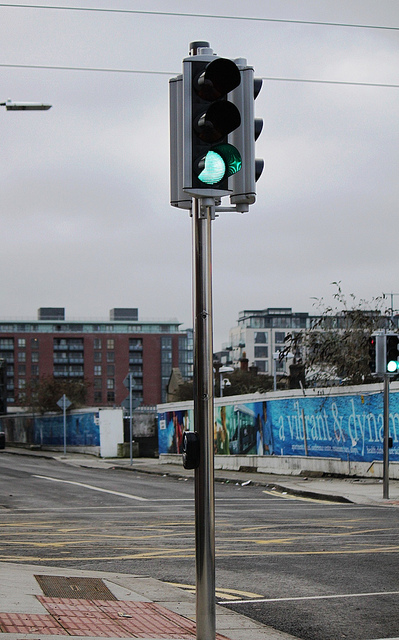

In [6]:
random_row = captions.sample(1).iloc[0]
print(random_row.caption)
print()
im = Image.open(random_row.image)
im

In [7]:
MAX_LENGTH = 40
VOCABULARY_SIZE = 500000
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512
EPOCHS = 5

In [8]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(captions['caption'])

In [9]:
tokenizer.vocabulary_size()

29080

In [19]:
import pickle

pickle.dump(tokenizer.get_vocabulary(), open('vocab_coco.file', 'wb'))

In [10]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [11]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(captions['image'], captions['caption']):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index], 
                                          img_keys[slice_index:])

train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector[imgv])

In [12]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(473392, 473392, 118361, 118361)

In [13]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    caption = tokenizer(caption)
    return img, caption

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [15]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

In [16]:
def CNN_Encoder():
    resnet50 = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet'
    )

    output = resnet50.output
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1]))(output)

    cnn_model = tf.keras.models.Model(resnet50.input, output)
    return cnn_model

In [17]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")
    

    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

In [48]:
class TransformerEncoderLayerDETR(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        dropout_rate=0.1

        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_1 = tf.keras.layers.Dense(embed_dim, activation="relu")
        self.dropout_1 = tf.keras.layers.Dropout(dropout_rate)
        self.dense_2 = tf.keras.layers.Dense(2048, activation="relu")
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.layer_norm_3 = tf.keras.layers.LayerNormalization()
        self.dropout_2 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout_3 = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, src, training):
        residual = src

        src = self.layer_norm_1(src)
        
        src = self.attention(
            query=src,
            value=src,
            key=src,
            attention_mask=None,
            training=training
        )

        src = residual + self.dropout_1(src)

        src = self.layer_norm_1(src)
    
        residual = src

        src = self.layer_norm_2(src)

        src = self.dense_2(self.dropout_2(self.dense_1(src)))

        src = residual + self.dropout_3(src)

        src = self.layer_norm_3(src)

        return src

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Activation, LayerNormalization


class TransformerEncoderDETR(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        dense_dim=2048
        dropout_rate=0.1
        l2_reg=1e-6
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.l2_reg = l2_reg

        self.attention_1 = tf.keras.layers.MultiHeadAttention(key_dim=embed_dim,
            num_heads=num_heads,  dropout=dropout_rate)
        
        self.dropout_1 = tf.keras.layers.Dropout(dropout_rate)

        self.dropout_2 = tf.keras.layers.Dropout(dropout_rate)

        self.dropout_3 = tf.keras.layers.Dropout(dropout_rate)

        self.activation_1 = tf.keras.layers.Activation('relu')

        self.linear1 = Linear(dense_dim)
        self.linear2 = Linear(dense_dim)
        

        self.layernorm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-5)

        self.layernorm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-5)

    def one_layer(self, source, training, mask=None):

        attn_source = self.attention_1(
            query=source,
            value=source,
            key=source,
            attention_mask=None
        )
        source += self.dropout_1(attn_source, training=training)
        
        source = self.layernorm_1(source)

        x = self.linear1(source)

        x = self.activation_1(x)

        x = self.dropout_2(x, training=training)
        
        x = self.linear1(x)

        source += self.dropout_3(x, training=training)

        source = self.layernorm_2(source)

        return source

    def call(self, inputs, training, mask=None):
        source = (inputs)
        
        # for i in range(6):
        inputs = self.one_layer(source, training, mask=None)
        
        inputs = self.linear2(inputs)
        return inputs
    
class Linear(tf.keras.layers.Layer):
    '''
    Use this custom layer instead of tf.keras.layers.Dense to allow
    loading converted PyTorch Dense weights that have shape (output_dim, input_dim)
    '''
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim


    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=[self.output_dim, input_shape[-1]],
                                      initializer=tf.keras.initializers.GlorotUniform(), trainable=True)
        self.bias = self.add_weight(name='bias',
                                    shape=[self.output_dim],
                                    initializer=tf.keras.initializers.GlorotUniform(), trainable=True)

    def call(self, x):
        return tf.matmul(x, self.kernel, transpose_b=True) + self.bias


    def compute_output_shape(self, input_shape):
        return input_shape.as_list()[:-1] + [self.output_dim]

In [18]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))
    

    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

In [19]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)
    

    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None
        
        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [20]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)
    

    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc

    
    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)
        
        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )
    
        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}
    

    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [21]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

In [22]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=cross_entropy
)

history = caption_model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

caption_model.save_weights('models/online-model-resnet50-epoch10-50deneme-10es-weights.h5')
tf.saved_model.save(caption_model, "models/online-model-epoch10-50deneme-10es-resnet50.h5")

Epoch 1/50


KeyboardInterrupt: 

In [30]:
caption_model.save_weights('models/online-model-resnet50-epoch10-50deneme-10es-weights.h5')
tf.saved_model.save(caption_model, "models/online-model-epoch10-50deneme-10es-resnet50.h5")


INFO:tensorflow:Assets written to: models/online-model-epoch10-resnet50.h5\assets


INFO:tensorflow:Assets written to: models/online-model-epoch10-resnet50.h5\assets


In [24]:
loaded_model = get_caption_model('models/online-model-resnet50-epoch10-weights.h5')

In [23]:
def get_caption_model(path):
    encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
    decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

    cnn_model = CNN_Encoder()

    caption_model = ImageCaptioningModel(
        cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=None,
    )

    def call_fn(batch, training):
        return batch

    caption_model.call = call_fn
    sample_x, sample_y = tf.random.normal((1, 299, 299, 3)), tf.zeros((1, 40))

    caption_model((sample_x, sample_y))

    sample_img_embed = caption_model.cnn_model(sample_x)
    sample_enc_out = caption_model.encoder(sample_img_embed, training=False)
    caption_model.decoder(sample_y, sample_enc_out, training=False)

    caption_model.load_weights(path)

    return caption_model

In [32]:
history.history

{'loss': [3.100504159927368,
  2.714791774749756,
  2.6188535690307617,
  2.560912609100342,
  2.516698122024536,
  2.482313632965088,
  2.4509031772613525,
  2.4234700202941895,
  2.4007081985473633,
  2.3796143531799316],
 'acc': [0.4221983253955841,
  0.4607551693916321,
  0.4714440703392029,
  0.4777565598487854,
  0.48291561007499695,
  0.4868580996990204,
  0.4908391833305359,
  0.49385109543800354,
  0.49673348665237427,
  0.4992183744907379],
 'val_loss': [2.872962236404419,
  2.7650094032287598,
  2.7174031734466553,
  2.7022864818573,
  2.6817467212677,
  2.680023670196533,
  2.6633267402648926,
  2.6683292388916016,
  2.672064781188965,
  2.676408290863037],
 'val_acc': [0.4431086480617523,
  0.45575711131095886,
  0.4614998698234558,
  0.46366897225379944,
  0.4663937985897064,
  0.46763065457344055,
  0.46953707933425903,
  0.4699859321117401,
  0.4692077338695526,
  0.4692015051841736]}

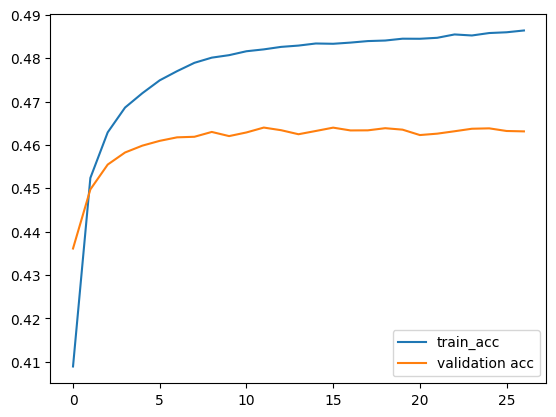

In [24]:
plt.plot(history.history['acc'], label='train_acc')
plt.plot(history.history['val_acc'], label='validation acc')
plt.legend()
plt.show()

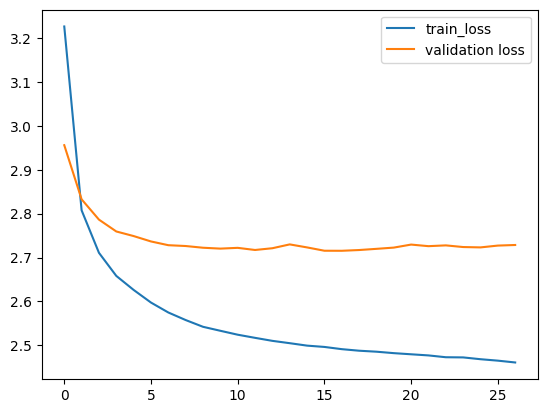

In [25]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [25]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img

caption_model = loaded_model
def generate_caption(img_path, add_noise=False):
    img = load_image_from_path(img_path)
    
    if add_noise:
        noise = tf.random.normal(img.shape)*0.1
        img = img + noise
        img = (img - tf.reduce_min(img))/(tf.reduce_max(img) - tf.reduce_min(img))
    
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)
        
        pred_idx = np.argmax(pred[0, i, :])
        pred_idx = tf.convert_to_tensor(pred_idx)
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break
        
        y_inp += ' ' + pred_word
    
    y_inp = y_inp.replace('[start] ', '')
    return y_inp

Predicted Caption: a dog is running in the grass with a frisbee



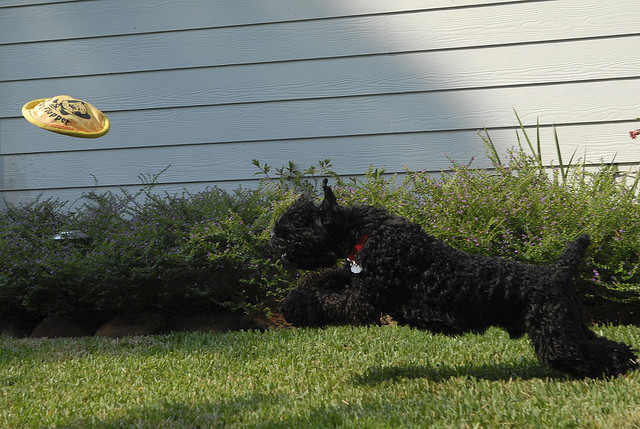

In [26]:
idx = random.randrange(0, len(captions))
img_path = captions.iloc[idx].image

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

In [69]:
import cv2
import pandas as pd
import random
from PIL import Image

# Open a video stream
video = 'C:/Users/IDAC PC/Desktop/UtkuThesis/mt-utku-elagoez/src/officevideo2.mp4'
cap = cv2.VideoCapture(video)
#cap = cv2.VideoCapture(0)  # Use 0 for the default camera
counter = 0
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    # Save the frame as a JPEG image
    img_path = "current_frame.jpg"
    cv2.imwrite(img_path, frame)
    # Generate caption for the frame
    if counter %100 == 0:

        pred_caption = generate_caption(img_path)
    
    # Display the frame with caption
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.6
    font_thickness = 2
    font_color = (255, 0, 0)  # Blue color in BGR
    text_position = (50, 50)
    
    cv2.putText(frame, pred_caption, text_position, font, font_scale, font_color, font_thickness, cv2.LINE_AA)
    cv2.imshow('Frame', frame)
    
    # Check if the user pressed 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
    counter += 1
# Release the capture
cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

Metrics

In [27]:
import pandas as pd
import json
import os
import numpy as np
import tensorflow as tf
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize

BASE_PATH = 'C:\\Users\\IDAC PC\\Desktop\\UtkuThesis\\ImageCaptioning1\\datasets\\coco2017'

# Load captions from JSON file
with open(os.path.join(BASE_PATH, 'annotations', 'captions_val2017.json'), 'r') as f:
    data = json.load(f)
    data = data['annotations']

# Prepare image-caption pairs
img_cap_pairs = []
for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([os.path.join(BASE_PATH, 'val2017', img_name), sample['caption']])

# Create a DataFrame for captions
captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])

# Function to load data
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))  # Resizing
    img = tf.keras.applications.resnet50.preprocess_input(img)
    caption = tokenizer(caption)
    return img, caption

# Function to generate captions
def generate_caption(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))  # Resizing
    img = tf.keras.applications.resnet50.preprocess_input(img)
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)
        
        pred_idx = np.argmax(pred[0, i, :])
        pred_idx = tf.convert_to_tensor(pred_idx)
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break
        
        y_inp += ' ' + pred_word
    
    y_inp = y_inp.replace('[start] ', '')
    return y_inp

# Function to tokenize captions
def tokenize_caption(caption):
    return word_tokenize(caption.lower())

# Function to evaluate BLEU
def evaluate_bleu(reference_captions, predicted_captions):
    references = [[tokenize_caption(ref)] for ref in reference_captions]
    hypothesis = [tokenize_caption(pred) for pred in predicted_captions]
    return corpus_bleu(references, hypothesis)

# Function to evaluate METEOR
def evaluate_meteor(reference_captions, predicted_captions):
    meteor_scores = []
    for pred in predicted_captions:
        meteor_scores.append(meteor_score(reference_captions, pred))
    return sum(meteor_scores) / len(meteor_scores)

# Load your trained model
caption_model = loaded_model  # You need to load your model here
MAX_LENGTH = 50  # Define your maximum caption length here
tokenizer = tokenizer  # Define your tokenizer here
idx2word = idx2word  # Define your idx2word converter here

# Example usage
predicted_captions = []
reference_captions = captions['caption'].tolist()  # Assuming captions is your DataFrame
image_paths = captions['image'].tolist()

for img_path in image_paths:
    caption = generate_caption(img_path)
    predicted_captions.append(caption)

bleu_score = evaluate_bleu(reference_captions, predicted_captions)
meteor_score = evaluate_meteor(reference_captions, predicted_captions)

print("BLEU Score:", bleu_score)
print("METEOR Score:", meteor_score)


KeyboardInterrupt: 

In [74]:
import pandas as pd
import json
import os
import numpy as np
import tensorflow as tf
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize

BASE_PATH = 'C:\\Users\\IDAC PC\\Desktop\\UtkuThesis\\ImageCaptioning1\\datasets\\coco2017'

# Load captions from JSON file
with open(os.path.join(BASE_PATH, 'annotations', 'captions_val2017.json'), 'r') as f:
    data = json.load(f)
    data = data['annotations']

# Prepare image-caption pairs
img_cap_pairs = []
for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([os.path.join(BASE_PATH, 'val2017', img_name), sample['caption']])

# Create a DataFrame for captions
captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])

# Sample down to 50 examples
captions = captions.sample(n=5)
captions.to_csv('captions.csv')

def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))  # Resizing
    img = tf.keras.applications.resnet50.preprocess_input(img)
    caption = tokenizer(caption)
    return img, caption

def generate_caption(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))  # Resizing
    img = tf.keras.applications.resnet50.preprocess_input(img)
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)
        
        pred_idx = np.argmax(pred[0, i, :])
        pred_idx = tf.convert_to_tensor(pred_idx)
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break
        
        y_inp += ' ' + pred_word
    
    y_inp = y_inp.replace('[start] ', '')
    return y_inp

# Function to tokenize captions
def tokenize_caption(caption):
    return word_tokenize(caption.lower())

# Function to evaluate BLEU
# Function to evaluate BLEU
def evaluate_bleu(reference_captions, predicted_captions):
    references = [[tokenize_caption(ref)] for ref in reference_captions]
    hypothesis = [tokenize_caption(pred) for pred in predicted_captions]
    bleu_scores = []
    for ref, hyp in zip(reference_captions, predicted_captions):
        bleu_score = corpus_bleu([[ref]], [hyp])
        print("Reference:", ref)
        print("Generated:", hyp)
        print("BLEU Score:", bleu_score)
        print("-" * 50)
        bleu_scores.append(bleu_score)
    return sum(bleu_scores) / len(bleu_scores)


def evaluate_meteor(reference_captions, predicted_captions):
    meteor_scores = []
    for pred, ref in zip(predicted_captions, reference_captions):
        pred_tokens = tokenize_caption(pred)  # Tokenize the predicted caption
        ref_tokens = tokenize_caption(ref)  # Tokenize the reference caption
        meteor_scores.append(meteor_score([ref_tokens], pred_tokens))
    return sum(meteor_scores) / len(meteor_scores)

# Load your trained model
caption_model = loaded_model  # You need to load your model here
MAX_LENGTH = 40  # Define your maximum caption length here
tokenizer = tokenizer  # Define your tokenizer here
idx2word = idx2word  # Define your idx2word converter here

# Example usage
predicted_captions = []
reference_captions = captions['caption'].tolist()  # Assuming captions is your DataFrame
image_paths = captions['image'].tolist()

for img_path in image_paths:
    caption = generate_caption(img_path)
    predicted_captions.append(caption)

bleu_score = evaluate_bleu(reference_captions, predicted_captions)
meteor_score = evaluate_meteor(reference_captions, predicted_captions)

print("BLEU Score:", bleu_score)
print("METEOR Score:", meteor_score)




Reference: A man is doing skateboard tricks on a ramp
Generated: a man riding a skateboard on a ramp
BLEU Score: 0.6164200207675533
--------------------------------------------------
Reference: A plane flying in the sky near an American flag.
Generated: a plane flying in the air with a sky in the background
BLEU Score: 0.5002168542431957
--------------------------------------------------
Reference: a woman standing at the end of a tennis court holding up a racket 
Generated: a tennis player is swinging his racket at a ball
BLEU Score: 0.3360024052599562
--------------------------------------------------
Reference: A woman wearing an Army t-shirt hits a tennis ball
Generated: a woman holding a tennis racquet on a tennis court
BLEU Score: 0.4348309418036513
--------------------------------------------------
Reference: A car sits next to a bus with things in front of it.
Generated: a red car parked next to a red car
BLEU Score: 0.24236448485234777
-----------------------------------------

In [1]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))  # Resizing
    img = tf.keras.applications.resnet50.preprocess_input(img)
    caption = tokenizer(caption)
    return img, caption

def generate_caption(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))  # Resizing
    img = tf.keras.applications.resnet50.preprocess_input(img)
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)
        
        pred_idx = np.argmax(pred[0, i, :])
        pred_idx = tf.convert_to_tensor(pred_idx)
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break
        
        y_inp += ' ' + pred_word
    
    y_inp = y_inp.replace('[start] ', '')
    return y_inp

# Function to tokenize captions
def tokenize_caption(caption):
    return word_tokenize(caption.lower())

# Function to evaluate BLEU
# Function to evaluate BLEU
def evaluate_bleu(reference_captions, predicted_captions):
    references = [[tokenize_caption(ref)] for ref in reference_captions]
    hypothesis = [tokenize_caption(pred) for pred in predicted_captions]
    bleu_scores = []
    for ref, hyp in zip(reference_captions, predicted_captions):
        bleu_score = corpus_bleu([[ref]], [hyp])
        print("Reference:", ref)
        print("Generated:", hyp)
        print("BLEU Score:", bleu_score)
        print("-" * 50)
        bleu_scores.append(bleu_score)
    return sum(bleu_scores) / len(bleu_scores)


def evaluate_meteor(reference_captions, predicted_captions):
    meteor_scores = []
    for pred, ref in zip(predicted_captions, reference_captions):
        pred_tokens = tokenize_caption(pred)  # Tokenize the predicted caption
        ref_tokens = tokenize_caption(ref)  # Tokenize the reference caption
        meteor_scores.append(meteor_score([ref_tokens], pred_tokens))
    return sum(meteor_scores) / len(meteor_scores)

# Load your trained model
caption_model = loaded_model  # You need to load your model here
MAX_LENGTH = 40  # Define your maximum caption length here
tokenizer = tokenizer  # Define your tokenizer here
idx2word = idx2word  # Define your idx2word converter here

# Example usage
predicted_captions = []
reference_captions = captions['caption'].tolist()  # Assuming captions is your DataFrame
image_paths = captions['image'].tolist()

for img_path in image_paths:
    caption = generate_caption(img_path)
    predicted_captions.append(caption)

bleu_score = evaluate_bleu(reference_captions, predicted_captions)
meteor_score = evaluate_meteor(reference_captions, predicted_captions)

print("BLEU Score:", bleu_score)
print("METEOR Score:", meteor_score)


NameError: name 'loaded_model' is not defined